# Project 3: Identifying Depression in r/domesticviolence Subreddit Posts
<img src="./images/domestic_violence.jpg" alt="domestic violence pic"/>

- [Webscraping and Data Collection](./1_Webscraping_and_Data_Collection.ipynb)
- [Preprocessing and EDA](./2_Preprocessing_and_EDA.ipynb)
- [Modeling - Multinomial Naive Bayes](./3_Modeling_Multinomial_Naive_Bayes.ipynb)
- [Modeling - Logistic Regression](./4_Modeling_Logistic_Regression.ipynb)
- [Modeling - Random Forest](./5_Modeling_Random_Forest.ipynb)
- <b>Production Model and Insights</b>

---
## Overview

In this notebook, the production model will be chosen out of the three best performing models based on three classifiers, namely, multinomial NB, logistic regression and random trees. Insights on the data from the production model will also be visualised and analysed in this notebook. The model will also be tested on an unseen post from r/domsticviolence which contains words that indicate depression, to see if it predicts the post as  ```is_depression``` = 1 (the goal of the project is to identidy depression based on posts in r/domesticviolence). Lastly, recommendations on how the model can be applied to more subreddits and suggestions on to make the model more robust and accurate will be included in the conclusion.

---
## Contents
- [Importing libraries and data](#Importing-libraries-and-data)
- [Choosing the production model](#Choosing-the-production-model)
- [The production model](#The-production-model)
- [Insights from production model](#Insights-from-production-model)
- [Testing model on unseen data](#Testing-model-on-unseen-data)
- [Conclusion and recommendations](#Conclusion-and-recommendations)

---
## Importing libraries and data

In [352]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
from PIL import Image

In [57]:
model_df = pd.read_csv('./data/dv_depression_cleaned_for_model_final.csv')
model_df.head()

,is_depression,post,title,post_word_count,all_words
0,0,unless get extremely stoned often come stop thinking really affecting life seeing therapist first appt emdr one 10 days help stop imagining beating thoughts like let go long tried writing poetry journaling helps temporarily want spend every day thinking anymore,get intrusive thoughts memories physical abuse,261,get intrusive thoughts memories physical abuse unless get extremely stoned often come stop thinking really affecting life seeing therapist first appt emdr one 10 days help stop imagining beating thoughts like let go long tried writing poetry journaling helps temporarily want spend every day thinking anymore
1,1,saw george floyd clip know part cries mama made think kids afraid cry mother father even made remember beyond toddler years never cried dad afraid crying never people thought needed someone remember always saying someone please save cried afraid childhood anymore fucked realized felt isolated completely alone far longer thought whole life stupid depressed fucks,kids afraid crying,363,kids afraid crying saw george floyd clip know part cries mama made think kids afraid cry mother father even made remember beyond toddler years never cried dad afraid crying never people thought needed someone remember always saying someone please save cried afraid childhood anymore fucked realized felt isolated completely alone far longer thought whole life stupid depressed fucks
2,1,sexual relationships since lost virginity bu shake habit masturbation matter much hated smoke tobacco occasionally use nicotine lot general vaping zyns toothpicks urge make feel better sinful acts gone see positive thing overall always complicated relationship nicotine must say appreciate lot beside point amp x200b post removed r asexuality unknown reasons maybe someone could help,nicotine replaced sexual urges,383,nicotine replaced sexual urges sexual relationships since lost virginity bu shake habit masturbation matter much hated smoke tobacco occasionally use nicotine lot general vaping zyns toothpicks urge make feel better sinful acts gone see positive thing overall always complicated relationship nicotine must say appreciate lot beside point amp x200b post removed r asexuality unknown reasons maybe someone could help
3,1,well end year 5 days hand rest school work done half mom trying make know able finish concentrate feels pointless online school literally makes want die family makes want die everything makes wanna die never perfect time die hate going punished laziness reality fucking stupid stupid work without crying getting distracted grade 9 know write fucking essay friends like fine mu parents disappointed supposed smart kid want even see much stupid quarantine taken toll mental health know marks fine fail nobody else seems seeing parents give shit edit whoever reached resources planning kill going rant parents school,hate school disappointment,613,hate school disappointment well end year 5 days hand rest school work done half mom trying make know able finish concentrate feels pointless online school literally makes want die family makes want die everything makes wanna die never perfect time die hate going punished laziness reality fucking stupid stupid work without crying getting distracted grade 9 know write fucking essay friends like fine mu parents disappointed supposed smart kid want even see much stupid quarantine taken toll mental health know marks fine fail nobody else seems seeing parents give shit edit whoever reached resources planning kill going rant parents school
4,1,anyone suffering depression job looking simple part time work,suffering depression job,61,suffering depression job anyone suffering depression job looking simple part time work


In [58]:
#no null values
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958 entries, 0 to 1957
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   is_depression    1958 non-null   int64 
 1   post             1958 non-null   object
 2   title            1958 non-null   object
 3   post_word_count  1958 non-null   int64 
 4   all_words        1958 non-null   object
dtypes: int64(2), object(3)
memory usage: 76.6+ KB


---
## Choosing the production model

In the multinomial NB, logistic regression and random forest modeling notebooks, the best model was identified and its parameters optimised. The performance of the 3 best models are as follows:

In [59]:
#importing results from best models 
multinomial_nb = pd.read_csv('./data/best_multinomial_nb.csv')
logreg = pd.read_csv('./data/best_logistic_regression.csv')
random_forest = pd.read_csv('./data/best_random_forest.csv')

In [60]:
best_results = pd.concat([multinomial_nb, logreg, random_forest])

pd.set_option('display.max_colwidth', None)
best_results

,features_matrix,model,optimised_params,train_score,test_score,confusion_matrix,sensitivity,specificity,precision,roc_auc_score,train_f1,test_f1
0,all_words,cvec + multinomial nb,"{'cvec__max_df': 0.7, 'cvec__max_features': 500, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}",0.937330,0.920408,"tn: 229, fp: 21, fn: 18, tp: 222",0.925000,0.916,0.913580,0.971950,0.935754,0.919255
0,all_words,tvec + logistic regression,"{'lr__C': 2.154434690031882, 'lr__penalty': 'l2', 'tvec__max_df': 0.7, 'tvec__max_features': 500, 'tvec__min_df': 6, 'tvec__ngram_range': (1, 1)}",0.969346,0.936735,"tn: 229, fp: 21, fn: 10, tp: 230",0.958333,0.916,0.916335,0.980483,0.968858,0.936864
0,all_words,tvec + random forest,"{'rf__max_depth': 50, 'rf__n_estimators': 500, 'tvec__max_df': 0.7, 'tvec__max_features': 500, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}",1.000000,0.918367,"tn: 227, fp: 23, fn: 17, tp: 223",0.929167,0.908,0.906504,0.963958,1.000000,0.917695


---
## The production model 

The best performing model is the Multinomial Naive Bayes model with Count Vectorizer, on the feature matrix ```all_words```, which contains all words from the subreddit title and post.  
- The train accuracy score (0.94) and test accuracy score (0.92) were high and had the least variance, which means that the model will generalise well to unseen data 
- Relatively high sensitivity score of 0.93 which shows minimal false negatives 
    - Type-II errors should be minimised for this project as it could be potentially costly to misclassify a post as ```is_depression``` = 0 when it should be ```is_depression``` = 1 (indicates author has depressive feelings)
- ROC AUC score of 0.97 is relatively high 
- Least variance between train f1 score (0.94) and test f1-score (0.92)

This model will now be fitted with its optimised parameters (as identified in in the dataframe)

In [382]:
#features matrix and target vector
X = model_df['all_words']
y = model_df['is_depression']

#train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, 
                                                    random_state = 42)

#fit count vectorizer with optimised params 
cvec = CountVectorizer(max_features = 500, max_df = 0.7, min_df = 1, ngram_range = (1,1))
X_train = cvec.fit_transform(X_train).toarray()
X_test = cvec.transform(X_test).toarray()

#fit multinomial nb model 
nb = MultinomialNB()
nb.fit(X_train, y_train)

#model performance 
train_score = nb.score(X_train, y_train)
test_score = nb.score(X_test, y_test)

preds = nb.predict(X_test)
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)

pred_proba = [i[1] for i in nb.predict_proba(X_test)]

roc_auc = roc_auc_score(y_test, pred_proba)
train_f1 = f1_score((nb.predict(X_train)), y_train)
test_f1 = f1_score(preds, y_test)

print('double-checking that performance scores are the same as dataframe...')
print(' ')
print(f'accuracy score for train set is {train_score}')
print(f'accuracy score for test set is {test_score}')
print(f'ROC AUC score is {roc_auc}')
print(f'sensitivity score is {sensitivity}')
print(f'specificity score is {specificity}')
print(f'precision score is {precision}')
print(f'train set f1-score is {train_f1}')
print(f'test set f1-score is {test_f1}')

double-checking that performance scores are the same as dataframe...
 
accuracy score for train set is 0.9373297002724795
accuracy score for test set is 0.9204081632653062
ROC AUC score is 0.97195
sensitivity score is 0.925
specificity score is 0.916
precision score is 0.9135802469135802
train set f1-score is 0.9357541899441341
test set f1-score is 0.9192546583850932


### ROC curve 

The ROC curve shows how well the model is at interpreting classes (0 and 1). The more area between the ROC (blue) curve and baseline (yellow line), the better separated the distributions of ```is_depression``` = 1 and ```is_depression``` = 0. An ROC AUC score of 0.97 means that the distribution is well separated, there is little overlap between false positive and false negatives, therefore minimising wrong predictions

In [62]:
pred_df = pd.DataFrame({'true_values': y_test,'pred_probs':pred_proba})
pred_df.head(2)

,true_values,pred_probs
353,0,4.485836e-40
1954,0,1.441273e-13


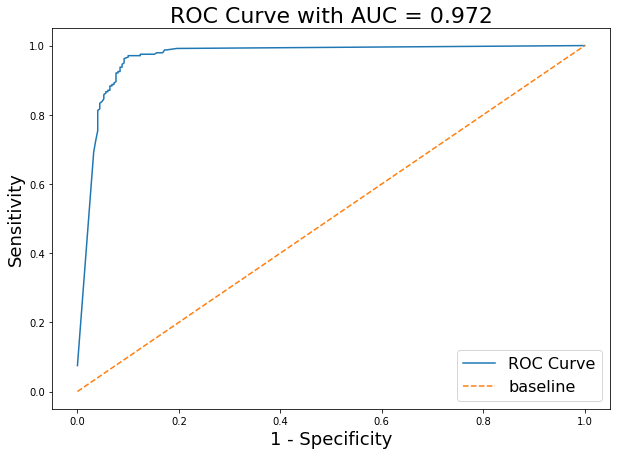

In [63]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f"ROC Curve with AUC = {round(roc_auc_score(pred_df['true_values'], pred_df['pred_probs']),3)}", 
          fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

---
## Insights from production model 

### Words with largest coefficient values 

From the top 500 most significant words (```max_features```), I have plotted a bar graph to show which words affect the prediction of target vector ```is_depression``` the most. The coefficients from the Multinomial NB model are all **negative**. They can be interpreted as follows.

**The top 20 words have the smallest negative coefficient values. They have the LEAST IMPACT in lowering the probability of ```is_depression```.** 
- The top 20 words are: ```like, feel, want, know, life, get, even, people, time, really, one, never, would, depression, friends, go, think, day, help, going```
- As word count of ```people``` increases by 1, the probability of target vector ```is_depression``` is **reduced by only 3.68 times**, i.e., higher probability of belonging in r/depression subreddit (```is_depression``` = 1) and lower probability of belonging in r/domesticviolence subreddit (```is_depression``` = 0)

**The bottom 20 words have the largest negative coefficient values. They have the MOST IMPACT in lowering the probability of ```is_depression```.**
- The bottom 20 words are: ```arrested, restraining, report, abuser, court, cops, domestic, verbally, threatened, violence, order, jail, yelling, hitting, kicked, hair, victim, apartment, police, violent```
- As word count of ```arrested``` increases by 1, the probability of target vector ```is_depression``` is **reduced by 10.55 times**, i.e., lower probability of belonging in r/depression subreddit (```is_depression``` = 1), therefore higher probability of belonging in the r/domesticviolence (```is_depression``` = 0)

### Barchart visualising top and bottom 20 words

In [64]:
#finding coefficients of 500 most siginificant features from model 
coefs = nb.coef_

features = cvec.get_feature_names()

coef_df = pd.DataFrame({'word':features, 'coef':coefs[0]})

#words with largest positive coefficient values 
top_20 = coef_df.sort_values(by = 'coef', ascending = False)[0:20]

#words with largest negative coefficient values 
bottom_20 = coef_df.sort_values(by = 'coef')[0:20] 

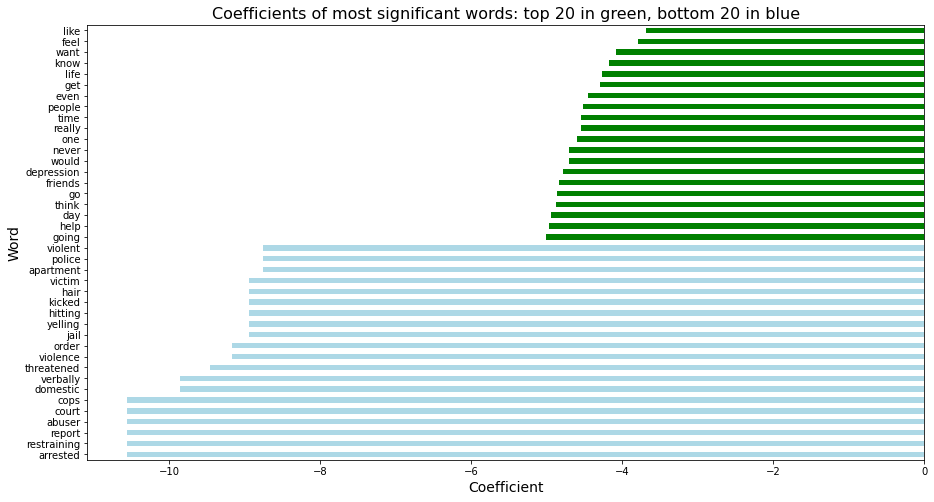

In [383]:
#plot bar chart with 20 words with largest coefficient values and 20 words with smallest coefficient values 
top_bottom_20 = pd.concat([bottom_20, top_20.sort_values(by = 'coef')], axis =0)

top_bottom_20.plot.barh('word', color=([np.where(top_bottom_20['coef']< -6, 'lightblue', 'green')]), 
                        figsize=(15,8))
plt.title('Coefficients of most significant words: top 20 in green, bottom 20 in blue', fontsize=16)
plt.xlabel('Coefficient', fontsize = 14)
plt.ylabel('Word', fontsize = 14)
plt.gca().legend_.remove();

### Wordcloud visualising top 100 words to predict ```is_depression``` = 1 and ```is_depression``` = 0

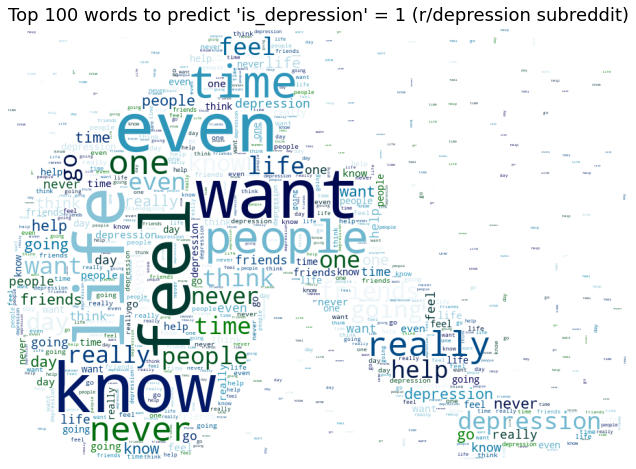

In [347]:
# Wordcloud visualising top 100 words to predict is_depression = 1

top_100 = coef_df.sort_values(by = 'coef', ascending = False)[0:100]

depression_mask = np.array(Image.open("./images/depression_mask.png"))
depression_mask = np.where(depression_mask == 0, 255, depression_mask) 

wordcloud = WordCloud(repeat=True, collocations=False,
                      min_font_size=5, max_font_size= 100, max_words= 1000, 
                      background_color= "white", 
                      colormap='ocean',
                      mask=depression_mask).generate(top_20['word'].to_string())
                                                                                            
plt.figure(figsize=[15,8])
plt.imshow(wordcloud, )
plt.axis("off")
plt.title("Top 100 words to predict 'is_depression' = 1 (r/depression subreddit)", fontsize= 18);

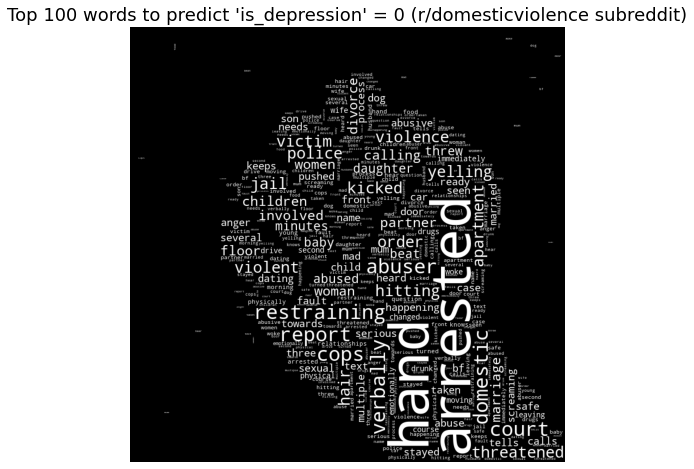

In [348]:
#Wordcloud visualising top 100 words to predict is_depression = 0 

bottom_100 = coef_df.sort_values(by = 'coef')[0:100] 

domestic_violence_mask = np.array(Image.open("./images/domestic_violence_mask.jpg"))
domestic_violence_mask = np.where(domestic_violence_mask == 0, 255, domestic_violence_mask) 


wordcloud = WordCloud(repeat=True, collocations=True,
                      min_font_size=5, max_font_size= 100, max_words= 1000, 
                      background_color= "black", 
                      color_func=lambda *args, **kwargs: "white",
                      mask=domestic_violence_mask).generate(bottom_100['word'].to_string())
                                                                                            
plt.figure(figsize=[15,8])
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Top 100 words to predict 'is_depression' = 0 (r/domesticviolence subreddit)", fontsize= 18);

---
## Testing model on unseen data

The model will now be tested on a post from r/domesticviolence containing indicating depression and a post that does not contain words indicating depression 

The link to the posts: 
- Post with words indicating depression 
    - https://www.reddit.com/r/domesticviolence/comments/heou9u/survivors_guilt_trigger_warning/
- Post without words indicating depression 
    - https://www.reddit.com/r/domesticviolence/comments/hdkx6c/i_finally_escaped_again/

The model made a positive prediction (```is_depression``` = 1) for the post containing many words indicating depression and a negative prediction (```is_depression``` = 0) for the post without words indicating depression 

This proves that the model is can be used to not just in differentiate posts from r/domesticviolence or r/depression, but also identify posts in r/domesticviolence that contain depressive words, where mental health groups can reach out and offer support and assistance to the author

In [118]:
#post in raw form has been extracted and put in .csv file
unseen = pd.read_csv('./data/unseen.csv')
unseen

,post,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,"Almost 3 years ago, I was attacked. My best guy friend tried to rape me and when I fought for as long as i could, he ended up beating me. It's a miracle that I didn't die, but I have a lifetime of effects, that I now have to deal with, including PTSD and severe memory loss. I also have seizures now. Sometimes I feel like I'm on top of the world, and other times like last night, the pain is so bad the only thing I can do is cry. Even thats painful. Sometimes I wish he would've just killed me. Took it all away but everytime i lost consciousness, he would do everything in his power to wake me up, so when id wake up id see him, just for him to continue kicking, punching, choking or fondling me. Im not suicidal but im not stable either. I hear people on the news who die from this shit everyday and had such amazing jobs and family and hell a life, and me, im unemployed, i don't have a high school diploma (im 20 btw, 17 when it happened) and I feel all alone . The black sheep of my family. So why are the best people with best lifes being taken. Granted I have a great mother, wonderful brother and exceptional boyfriend who helps me, i just feel guilty. Guilty I survived and the pain its brought everyone around me. Including myself. Im just so tired. I hope to wake up soon.",NaN,NaN,NaN,NaN,NaN
1,"I feel stupid for going back to my ex, but I had nowhere to go during the Coronavirus Quarantine. I spent 3 months at his house and it was great in the beginning. He was so nice, always complimenting me, spending time with me, doing things for me, etc. towards the end though, things got bad again. He started using drugs, being emotionally and physically abusive, and forcing me to do everything around the house. Any money I had would be taken away from me to support his drug habit. He stopped being interested in me and wouldn’t spend any time with me. I felt so alone and the fact that I couldn’t go anywhere made things so much worse. It finally came to a head when he woke me up one morning demanding money. Somehow he had figured out that a friend from Guam had sent me $50 to renew my I.D. He must have unlocked my phone while I was sleeping with my fingerprint and gone through my messages. I could tell that he was sick from not having his drugs and I refused to go get the money for him. He proceeded to beat me all over and pull me out of the bed by my hair. I screamed for help and after kicking me in my abdomen a few times he left me alone. I managed to pull myself up and lock the bedroom door before he came back and hurt me some more. I was genuinely afraid that he was going to kill me (I’m very petite and he is very big, 6ft.10 and 300 lbs.) I was laying on the bed trying to recover from the beating when I heard a knock on the door and a voice saying “Police! Open up!” He had actually called the cops on me! When I opened the door I was grateful to see an officer who had helped me in the past and knew that my ex had a history of abuse and a problem with drugs. As I was leaving with the officer I passed out. He had to call an ambulance and I was taken to the hospital where I was admitted and kept for observation for that day and night. During the attack, he had given me a concussion, a black eye, and caused bruising to my kidneys.\nOnce the doctor determined that I was ok to be released, they realized that I had nowhere to go. They contacted the local domestic violence shelter where I had stayed before and they were full. I ended up at the city homeless shelter, where I had been attacked before. That shelter is full of drugs and violence, in fact, the police were called that night for a fight involving 5 men, one of which ended up in the hospital in critical condition. After a sleepless night on a hard cot, I spent the day at social services trying to find a place to stay. I was still in my pajamas and slippers from the morning I left. Thankfully the shelter placed me in a hotel ro

In [119]:
unseen.drop(['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'], axis=1, inplace=True)
unseen

,post
0,"Almost 3 years ago, I was attacked. My best guy friend tried to rape me and when I fought for as long as i could, he ended up beating me. It's a miracle that I didn't die, but I have a lifetime of effects, that I now have to deal with, including PTSD and severe memory loss. I also have seizures now. Sometimes I feel like I'm on top of the world, and other times like last night, the pain is so bad the only thing I can do is cry. Even thats painful. Sometimes I wish he would've just killed me. Took it all away but everytime i lost consciousness, he would do everything in his power to wake me up, so when id wake up id see him, just for him to continue kicking, punching, choking or fondling me. Im not suicidal but im not stable either. I hear people on the news who die from this shit everyday and had such amazing jobs and family and hell a life, and me, im unemployed, i don't have a high school diploma (im 20 btw, 17 when it happened) and I feel all alone . The black sheep of my family. So why are the best people with best lifes being taken. Granted I have a great mother, wonderful brother and exceptional boyfriend who helps me, i just feel guilty. Guilty I survived and the pain its brought everyone around me. Including myself. Im just so tired. I hope to wake up soon."
1,"I feel stupid for going back to my ex, but I had nowhere to go during the Coronavirus Quarantine. I spent 3 months at his house and it was great in the beginning. He was so nice, always complimenting me, spending time with me, doing things for me, etc. towards the end though, things got bad again. He started using drugs, being emotionally and physically abusive, and forcing me to do everything around the house. Any money I had would be taken away from me to support his drug habit. He stopped being interested in me and wouldn’t spend any time with me. I felt so alone and the fact that I couldn’t go anywhere made things so much worse. It finally came to a head when he woke me up one morning demanding money. Somehow he had figured out that a friend from Guam had sent me $50 to renew my I.D. He must have unlocked my phone while I was sleeping with my fingerprint and gone through my messages. I could tell that he was sick from not having his drugs and I refused to go get the money for him. He proceeded to beat me all over and pull me out of the bed by my hair. I screamed for help and after kicking me in my abdomen a few times he left me alone. I managed to pull myself up and lock the bedroom door before he came back and hurt me some more. I was genuinely afraid that he was going to kill me (I’m very petite and he is very big, 6ft.10 and 300 lbs.) I was laying on the bed trying to recover from the beating when I heard a knock on the door and a voice saying “Police! Open up!” He had actually called the cops on me! When I opened the door I was grateful to see an officer who had helped me in the past and knew that my ex had a history of abuse and a problem with drugs. As I was leaving with the officer I passed out. He had to call an ambulance and I was taken to the hospital where I was admitted and kept for observation for that day and night. During the attack, he had given me a concussion, a black eye, and caused bruising to my kidneys.\nOnce the doctor determined that I was ok to be released, they realized that I had nowhere to go. They contacted the local domestic violence shelter where I had stayed before and they were full. I ended up at the city homeless shelter, where I had been attacked before. That shelter is full of drugs and violence, in fact, the police were called that night for a fight involving 5 men, one of which ended up in the hospital in critical condition. After a sleepless night on a hard cot, I spent the day at social services trying to find a place to stay. I was still in my pajamas and slippers from the morning I left. Thankfully the shelter placed me in a hotel room. I have been moved from hotel to hotel since then and have slowly been t

In [120]:
# preprocessing post column in unseen
def preprocess(word):
    
    #tokenize and convert lower 
    # \w also removes punctuation - may need to add extra no punc if tokenizing does not do it
    token = RegexpTokenizer(r'\w+')
    tokens = token.tokenize(word.lower())
    
   #remove stopwords 
    stops = set(stopwords.words('english'))
    no_stop = [word for word in tokens if word not in stops]

    no_stopword = (' '.join(no_stop))
        
    #lemmatize words
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(word) for word in no_stopword]
    
    #return words as a single string 
    return(''.join(lem))

In [121]:
post_clean = []

for word in unseen["post"]:
    post_clean.append(preprocess(word))

unseen['post_clean'] = post_clean

In [122]:
#drop 'post' column
unseen.drop(['post'], axis =1, inplace=True)
unseen

,post_clean
0,almost 3 years ago attacked best guy friend tried rape fought long could ended beating miracle die lifetime effects deal including ptsd severe memory loss also seizures sometimes feel like top world times like last night pain bad thing cry even thats painful sometimes wish would killed took away everytime lost consciousness would everything power wake id wake id see continue kicking punching choking fondling im suicidal im stable either hear people news die shit everyday amazing jobs family hell life im unemployed high school diploma im 20 btw 17 happened feel alone black sheep family best people best lifes taken granted great mother wonderful brother exceptional boyfriend helps feel guilty guilty survived pain brought everyone around including im tired hope wake soon
1,feel stupid going back ex nowhere go coronavirus quarantine spent 3 months house great beginning nice always complimenting spending time things etc towards end though things got bad started using drugs emotionally physically abusive forcing everything around house money would taken away support drug habit stopped interested spend time felt alone fact go anywhere made things much worse finally came head woke one morning demanding money somehow figured friend guam sent 50 renew must unlocked phone sleeping fingerprint gone messages could tell sick drugs refused go get money proceeded beat pull bed hair screamed help kicking abdomen times left alone managed pull lock bedroom door came back hurt genuinely afraid going kill petite big 6ft 10 300 lbs laying bed trying recover beating heard knock door voice saying police open actually called cops opened door grateful see officer helped past knew ex history abuse problem drugs leaving officer passed call ambulance taken hospital admitted kept observation day night attack given concussion black eye caused bruising kidneys doctor determined ok released realized nowhere go contacted local domestic violence shelter stayed full ended city homeless shelter attacked shelter full drugs violence fact police called night fight involving 5 men one ended hospital critical condition sleepless night hard cot spent day social services trying find place stay still pajamas slippers morning left thankfully shelter placed hotel room moved hotel hotel since slowly trying get life back difficult least away safe weekly visitation daughter quarantine anymore


In [123]:
#fit cvec for unseen data 
unseen_cvec = cvec.transform(unseen['post_clean']).toarray()

#predict if unseen is 'is_depression' = 0 or 1
prediction = nb.predict(unseen_cvec)
unseen['is_depression'] = pd.DataFrame(prediction)
unseen

,post_clean,is_depression
0,almost 3 years ago attacked best guy friend tried rape fought long could ended beating miracle die lifetime effects deal including ptsd severe memory loss also seizures sometimes feel like top world times like last night pain bad thing cry even thats painful sometimes wish would killed took away everytime lost consciousness would everything power wake id wake id see continue kicking punching choking fondling im suicidal im stable either hear people news die shit everyday amazing jobs family hell life im unemployed high school diploma im 20 btw 17 happened feel alone black sheep family best people best lifes taken granted great mother wonderful brother exceptional boyfriend helps feel guilty guilty survived pain brought everyone around including im tired hope wake soon,1
1,feel stupid going back ex nowhere go coronavirus quarantine spent 3 months house great beginning nice always complimenting spending time things etc towards end though things got bad started using drugs emotionally physically abusive forcing everything around house money would taken away support drug habit stopped interested spend time felt alone fact go anywhere made things much worse finally came head woke one morning demanding money somehow figured friend guam sent 50 renew must unlocked phone sleeping fingerprint gone messages could tell sick drugs refused go get money proceeded beat pull bed hair screamed help kicking abdomen times left alone managed pull lock bedroom door came back hurt genuinely afraid going kill petite big 6ft 10 300 lbs laying bed trying recover beating heard knock door voice saying police open actually called cops opened door grateful see officer helped past knew ex history abuse problem drugs leaving officer passed call ambulance taken hospital admitted kept observation day night attack given concussion black eye caused bruising kidneys doctor determined ok released realized nowhere go contacted local domestic violence shelter stayed full ended city homeless shelter attacked shelter full drugs violence fact police called night fight involving 5 men one ended hospital critical condition sleepless night hard cot spent day social services trying find place stay still pajamas slippers morning left thankfully shelter placed hotel room moved hotel hotel since slowly trying get life back difficult least away safe weekly visitation daughter quarantine anymore,0


---
## Conclusion and recommendations

The model has showed that it is able to classify posts from r/domestic violence containing depressive words as ```is_depression``` = 1. Thus, it can be used on extracted posts from the r/domesticviolence subreddit to identify posts containing words that indicate that the author is suffering from depression. Thus, instead of waiting for these authors to reach out for help, the model allows a more proactive approach to be taken with extending mental health support. The authors of these posts can be identified by their user IDs, which can be passed on to mental health support groups. 

### Recommendations

This model is just the tip of the iceberg in the relatively new usage of Natural Language Processing to predict mental health issues<sup>[[3]](https://www.hindawi.com/journals/cmmm/2016/8708434/)</sup>. As the use of social media and discussion sites such as Reddit increases, the need for such tools will become increasingly important, particularly in light of increased domestic violence incidents due to COVID-19.

Going forward, there are several things that can be done to improve on this model
- Gather more data
    - Only 1000 posts were scraped from r/domesticviolence and r/depression. More posts can be extracted to make the model more robust by introducing more words
- Run data on more classification models 
    - While a good score was obtained from the multinomial NB model, the data can be run on other models such as SVM which, due to the time constraints on this project I was unable to do.
- Introduce a ```is_suicide``` classification 
    - In the top words predicting ```is_depression``` = 1, words like suicide and suicidal have surfaced, indicating suicidal thoughts by the author. Thus, the model can be expanded to include posts from the r/SuicideWatch subreddit to identify if authors of posts in r/domesticviolence have suicidal thoughts.
- The ```is_depression``` classification can be adapted to other subreddits where people post about their traumatic experiences to help more groups of people (i.e., similar to r/domesticviolence)
- Modeling can be done on the ```post_word_count``` column to boost the accuracy of ```is_depression``` predictions
    - EDA showed that the length of r/domesticviolence posts were longer than r/depression posts, an indicator that length of post could be a factor in ```is_depression``` predicictions.